# Exemple de Recurrent Neurone Network pour la Prediction de Temperature 

In [4]:
import pandas as pd
data = pd.read_csv('meteo_dataset')

data.columns

Index(['Pressure', 'Temperature', 'Saturation vapor pressure',
       'Vapor pressure deficit', 'Specific humidity', 'Airtight',
       'Wind speed'],
      dtype='object')

In [5]:
data.shape

(420551, 7)

### Visualisation de données 

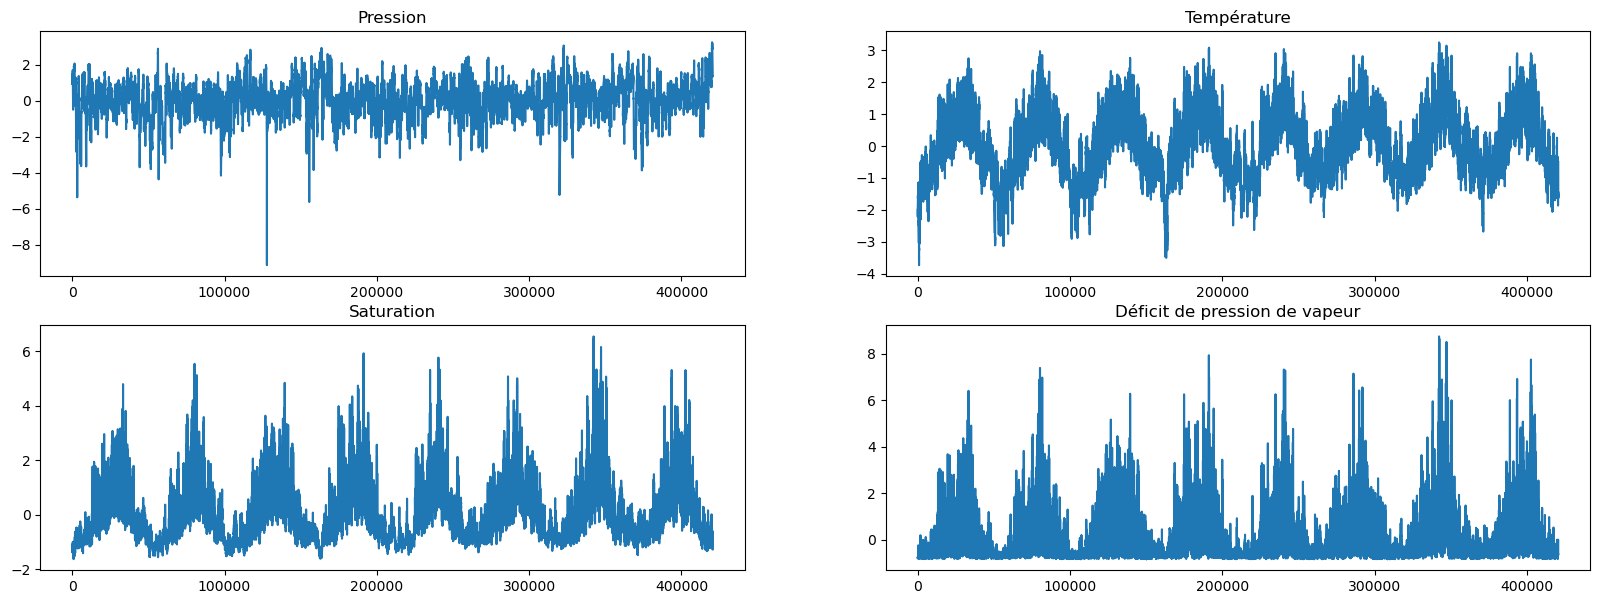

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,7))
# Évolution de la pression
ax1 = fig.add_subplot(221)
plt.plot(data['Pressure'])
ax1.title.set_text('Pression')
# Évolution de la température
ax2 = fig.add_subplot(222)
plt.plot(data['Temperature'])
ax2.title.set_text('Température')
# Évolution de la saturation
ax3 = fig.add_subplot(223)
plt.plot(data['Saturation vapor pressure'])
ax3.title.set_text('Saturation')
# Évolution du déficit de pression de vapeur
ax4 = fig.add_subplot(224)
plt.plot(data['Vapor pressure deficit'])
ax4.title.set_text('Déficit de pression de vapeur')
plt.show()

In [7]:
split_fraction = 0.80
split_idx =int(split_fraction * len(data))
# Train: on conserve les 80% premières lignes
train_data = data.loc[0:split_idx-1].values
# Test: on conserve les 20% dernières lignes
val_data = data.loc[split_idx:].values
print(f"Jeu d'apprentissage : {train_data.shape}, jeu d'évaluation : {val_data.shape}")


Jeu d'apprentissage : (336440, 7), jeu d'évaluation : (84111, 7)


le modèle décisionnel consiste à prédire une séquence (la température) à partir d’une séquence de variables explicatives 
 (les autres paramètres).

# entraîner notre réseau de neurones par descente de gradient

In [12]:
# Importation 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib as plt


In [23]:

# Création du jeu d'entraînement

sampling_rate = 6 # Fréquence d'échantillonnage
sequence_length = 120  # Longueur de la séquence
batch_size = 256 # Taille de batch

# Création du jeu d'entraînement

X_train = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data[:, (0,2,3,4,5,6)],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

y_train = tf.keras.utils.timeseries_dataset_from_array(
    data=train_data[:, 1],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)


dataset_train = tf.data.Dataset.zip((X_train, y_train))

# Création du jeu d'évaluation

X_val = tf.keras.utils.timeseries_dataset_from_array(
    data=val_data[:, (0,2,3,4,5,6)],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

y_val = tf.keras.utils.timeseries_dataset_from_array(
    data=val_data[:, 1],
    targets=None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

dataset_val = tf.data.Dataset.zip((X_val, y_val))

## training NN 

In [24]:
from tensorflow import keras

La fonction de perte utilisée pour la régression sera l’erreur quadratique moyenne (MSE)

In [25]:
dimension = train_data.shape[1]-1
inputs = keras.layers.Input(shape=(sequence_length, dimension))
gru_out = keras.layers.GRU(dimension, return_sequences=True)(inputs)
dense_out = keras.layers.Dense(dimension, activation='relu')(gru_out)
outputs = keras.layers.Dense(1)(dense_out)

model = keras.Model(inputs=inputs, outputs=outputs)

Concernant l’optimisation, nous allons utiliser le solveur Adam pour la descente de gradient. On fixe le pas d’apprentissage à 
0,001 pour l’instant. Nous pouvons compiler le modèle avec Keras :

In [26]:
learning_rate = 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 6)]          0         
                                                                 
 gru (GRU)                   (None, 120, 6)            252       
                                                                 
 dense (Dense)               (None, 120, 6)            42        
                                                                 
 dense_1 (Dense)             (None, 120, 1)            7         
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [27]:
epochs = 5

model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
)

Epoch 1/5
1312/1312 [==============================] - 125s 90ms/step - loss: 0.1510 - val_loss: 0.0245
Epoch 2/5
1312/1312 [==============================] - 113s 86ms/step - loss: 0.0157 - val_loss: 0.0075
Epoch 3/5
1312/1312 [==============================] - 118s 90ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 4/5
1312/1312 [==============================] - 112s 86ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 5/5
1312/1312 [==============================] - 113s 86ms/step - loss: 0.0016 - val_loss: 9.0892e-04


In [49]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import scatter
def show_plot(predicted_data, true_data):
    plt.title('Prédiction synchrone')
    plt.plot(predicted_data, "rx", label="Température prédite")
    plt.plot(true_data, ".-", label="Vraie température")
    plt.legend()
    plt.xlabel("Pas de temps")
    plt.show()
    return

À l’aide de la méthode predict de Keras, on calcule les prédictions de température pour les trois premières séquences x du jeu de données de validation.

8/8 [==============================] - 0s 13ms/step


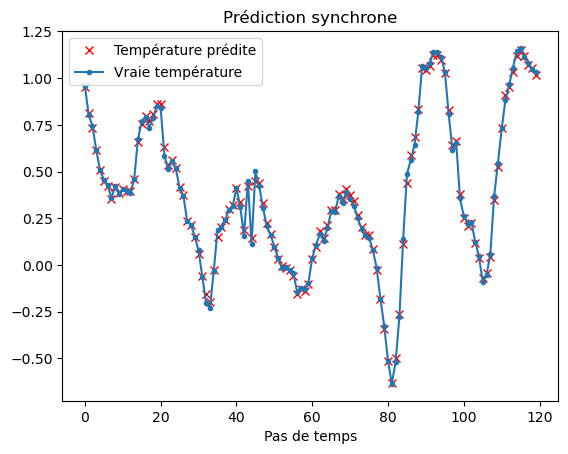

8/8 [==============================] - 0s 12ms/step


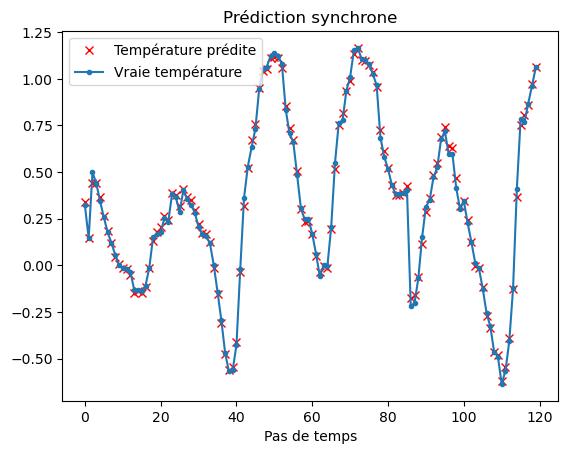

8/8 [==============================] - 0s 12ms/step


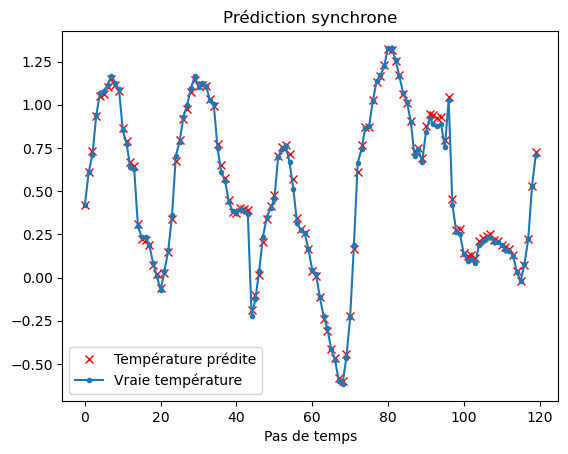

In [50]:
for x, y in dataset_val.take(3):
     show_plot(y[0].numpy(), model.predict(x)[0])

### Les prédictions de température sont très proches de la vérité terrain. Les performances en train et en test sont bonnes et à peu près équivalentes, ce qui signifie a priori qu’il n’y a pas de surapprentrissage.

In [53]:
mean_absolute_error = tf.keras.losses.MeanAbsoluteError()
error = 0

for x, y in dataset_val:
    y_pred = model(x)
    error += mean_absolute_error(y, y_pred).numpy()

print(f"Erreur absolue moyenne : {error/len(dataset_val):.5f}")


Erreur absolue moyenne : 0.02036


# Prédiction de la température future

In [54]:
past_length = 720
future_step = 6

label_start = past_length + future_step  # Début de la séquence des labels
label_end = label_start + split_idx  # Fin de la séquence des labels

x_train = train_data
y_train = data[label_start:label_end][['Temperature']]

x_end = len(val_data) - past_length - future_step # Fin de la séquence des données d'entrées en validation

label_start = split_idx + past_length + future_step # Début de la séquence des labels en validation
x_val = val_data[:x_end]
y_val = data[label_start:][['Temperature']]

In [55]:
batch_size = 256
step_size = 6 # Facteur d'échantillonnage
sequence_length = int(past_length / step_size)

dataset_train = tf.keras.utils.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step_size,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step_size,
    batch_size=batch_size,
)

#### Comme précédemment, nous allons entraîner un réseau récurrent constitué d’une couche récurrente utilisant la cellule GRU et de deux couches linéaires séparées par une activation ReLU.

In [56]:
learning_rate = 0.001

input_dim = train_data.shape[1]
hidden_dim = 32
inputs = keras.layers.Input(shape=(sequence_length, input_dim))
gru_out = keras.layers.GRU(hidden_dim)(inputs)
dense_out = keras.layers.Dense(hidden_dim, activation='relu')(gru_out)
outputs = keras.layers.Dense(1)(dense_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 gru_1 (GRU)                 (None, 32)                3936      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [57]:
epochs = 5

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
)

Epoch 1/5
1312/1312 [==============================] - 194s 146ms/step - loss: 0.0565 - val_loss: 0.0618
Epoch 2/5
1312/1312 [==============================] - 204s 155ms/step - loss: 0.0284 - val_loss: 0.0496
Epoch 3/5
1312/1312 [==============================] - 186s 141ms/step - loss: 0.0254 - val_loss: 0.0506
Epoch 4/5
1312/1312 [==============================] - 188s 144ms/step - loss: 0.0242 - val_loss: 0.0466
Epoch 5/5
1312/1312 [==============================] - 202s 154ms/step - loss: 0.0224 - val_loss: 0.0355


Pour terminer, on peux désormais visualisons les résultats en prédiction de notre modèle sur les trois premières séquences du jeu de validation :

In [58]:
def show_plot(sequence, prediction, ground_truth, delta=future_step/step_size, title=None):
    plt.title(title)
    plt.plot(sequence.flatten(), ".-", label="Température passée")
    plt.plot(len(sequence) + delta, prediction, "go", label="Prédiction")
    plt.plot(len(sequence) + delta, ground_truth, "rx", label="Vraie température")
    plt.legend()
    plt.xlim(-1, len(sequence) + delta + 3)
    plt.xlabel("Pas de temps")
    plt.show()

8/8 [==============================] - 1s 14ms/step


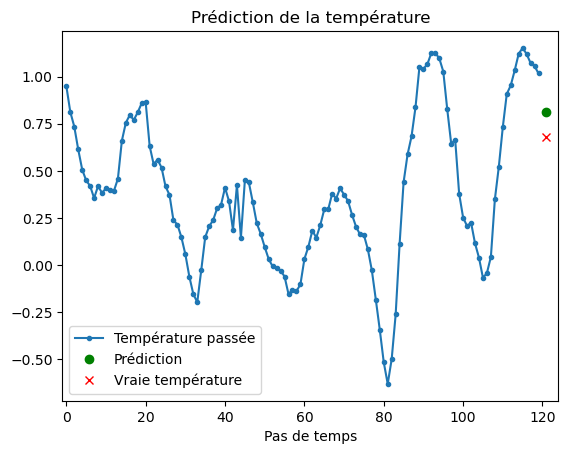

8/8 [==============================] - 0s 14ms/step


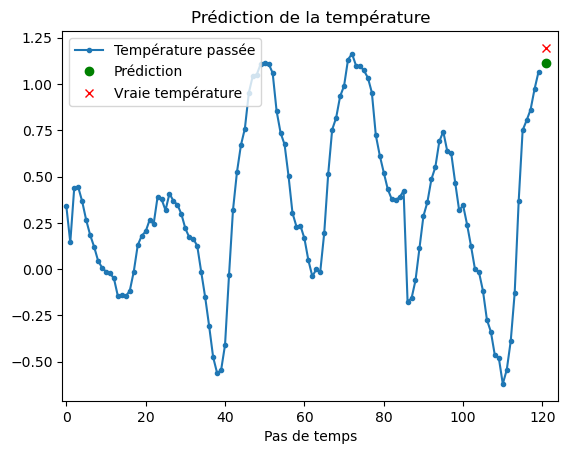

8/8 [==============================] - 0s 14ms/step


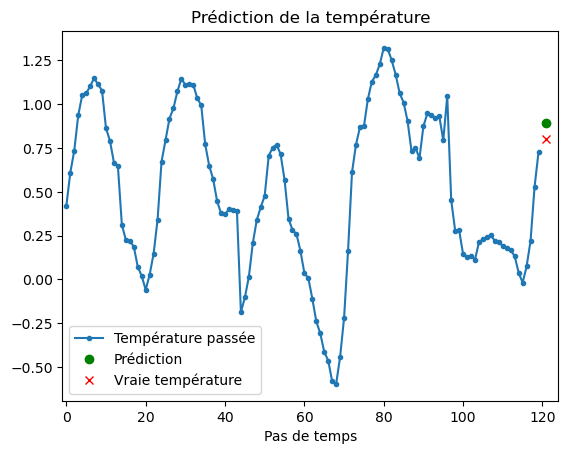

8/8 [==============================] - 0s 15ms/step


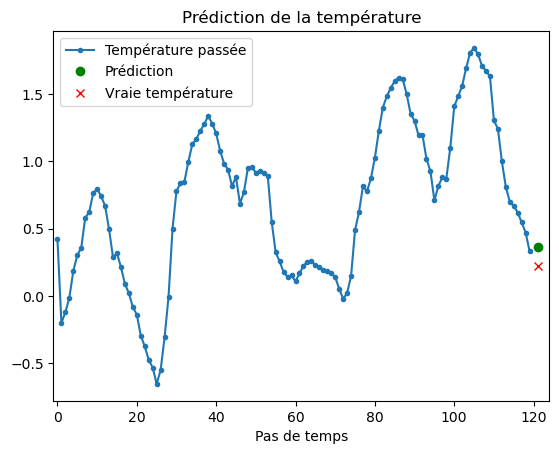

8/8 [==============================] - 0s 14ms/step


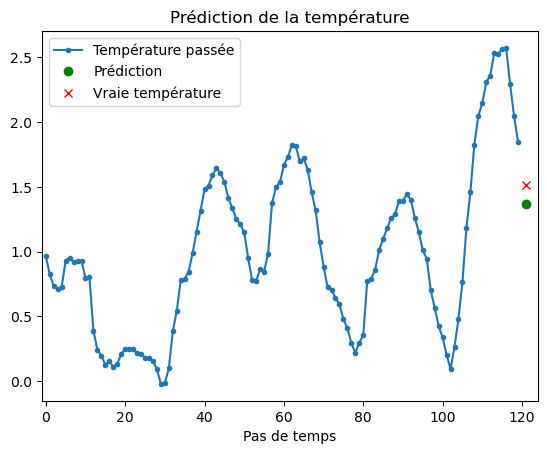

In [59]:
for x, y in dataset_val.take(5):
    show_plot(x[0][:, 1].numpy(), model.predict(x)[0], y[0].numpy(), title="Prédiction de la température")

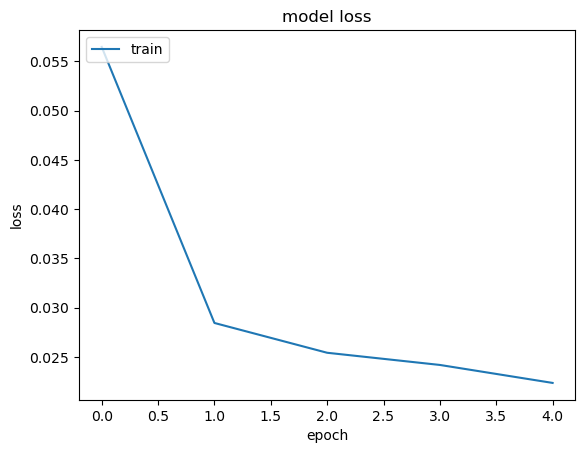

In [65]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()